## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [207]:
"""
TODO: Add AT1 bond data
TODO: Find interest rates (Yield curve/credit spread?)
"""

'\nTODO: Add AT1 bond data\nTODO: Find interest rates (Yield curve/credit spread?)\n'

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf  # Cufflinks
import configparser as cp
import warnings

# Remove Eikon API depreciation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [209]:
# ================================================================
#                     Load data from Reuters
# ================================================================

def load_timeseries_data(data_folder = "data") -> pd.DataFrame: 
    """
    Load timeseries data from Reuters
    """

    close_df              = pd.read_excel(f'{data_folder}/cs_close.xlsx', index_col = 0, parse_dates = True)
    shares_outstanding_df = pd.read_excel(f'{data_folder}/cs_shares_outstanding.xlsx', index_col = 0, parse_dates = True)
    market_cap_df         = pd.read_excel(f'{data_folder}/cs_market_cap.xlsx', index_col = 0, parse_dates = True)
    total_assets_df       = pd.read_excel(f'{data_folder}/cs_total_assets.xlsx', index_col = 0, parse_dates = True)
    total_debt_df         = pd.read_excel(f'{data_folder}/cs_total_debt.xlsx', index_col = 0, parse_dates = True)
    # at1_debt_df           = pd.read_excel(f'{data_folder}/cs_at1_debt.xlsx', index_col = 0, parse_dates = True)

    # Drop duplicates
    close_df              = close_df[~close_df.index.duplicated(keep='first')]
    shares_outstanding_df = shares_outstanding_df[~shares_outstanding_df.index.duplicated(keep='first')]
    market_cap_df         = market_cap_df[~market_cap_df.index.duplicated(keep='first')]
    total_assets_df       = total_assets_df[~total_assets_df.index.duplicated(keep='first')]
    total_debt_df         = total_debt_df[~total_debt_df.index.duplicated(keep='first')]
    # at1_debt_df           = at1_debt_df[~at1_debt_df.index.duplicated(keep='first')]
    # TODO: see if we can drop duplicates in the original data

    # Fill days inbetween with the last available value
    start_date = close_df.index.min()
    end_date = close_df.index.max()
    full_range = pd.date_range(
        start=start_date - pd.DateOffset(years=1),
        end=end_date,
    )
    close_df = close_df.reindex(full_range).ffill()
    shares_outstanding_df = shares_outstanding_df.reindex(full_range).ffill()
    market_cap_df = market_cap_df.reindex(full_range).ffill()
    total_assets_df = total_assets_df.reindex(full_range).ffill()
    total_debt_df = total_debt_df.reindex(full_range).ffill()
    # at1_debt_df = at1_debt_df.reindex(full_range).ffill()

    # Remove non-business days
    full_range = pd.date_range(
        start=start_date,
        end=end_date,
        freq='B'
    )
    close_df = close_df.reindex(full_range)
    shares_outstanding_df = shares_outstanding_df.reindex(full_range)
    market_cap_df = market_cap_df.reindex(full_range)
    total_assets_df = total_assets_df.reindex(full_range)
    total_debt_df = total_debt_df.reindex(full_range)
    # at1_debt_df = at1_debt_df.reindex(full_range)
    # TODO: Remove non-business days

    # print(close_df)
    # print(shares_outstanding_df)
    # print(market_cap_df)
    # print(total_assets_df)
    # print(total_debt_df)
    # print(at1_debt_df)

    input_data = close_df.merge(shares_outstanding_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(market_cap_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_assets_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_debt_df, left_index=True, right_index=True, how='left')
    # input_data = input_data.merge(at1_debt_df, left_index=True, right_index=True, how='left')

    return input_data

# # Shares outstanding from book value data:
# shares_outstanding = {
#     "2018": 2_550_600_000, 
#     "2019": 2_436_200_000, 
#     "2020": 2_406_144_879, 
#     "2021": 2_569_684_509, 
#     "2022": 3_941_250_081
# }

input_data = load_timeseries_data()

# input_data["Calculated market cap"] = input_data["Close"] * input_data["Common Shares - Outstanding - Total"]
# input_data[["Calculated market cap", "Company Market Cap"]].plot()


# input_data.plot()
input_data


,Close,Issue Default Shares Outstanding,Company Market Capitalization,Total Assets,Total Debt
2018-01-03,16.630954,2.556012e+09,4.744485e+10,7.962890e+11,2.634910e+11
2018-01-04,16.877058,2.556012e+09,4.814694e+10,7.962890e+11,2.634910e+11
2018-01-05,16.697213,2.556012e+09,4.763387e+10,7.962890e+11,2.634910e+11
2018-01-08,16.824997,2.556012e+09,4.799842e+10,7.962890e+11,2.634910e+11
2018-01-09,16.867592,2.556012e+09,4.811993e+10,7.962890e+11,2.634910e+11
...,...,...,...,...,...
2023-06-06,0.809600,4.002158e+09,3.240147e+09,5.313580e+11,1.929070e+11
2023-06-07,0.810200,4.002158e+09,3.242548e+09,5.313580e+11,1.929070e+11
2023-06-08,0.811000,4.002158e+09,3.245750e+09,5.313580e+11,1.929070e+11
2023-06-09,0.808000,4.002158e+09,3.233744e+09,5.313580e+11,1.929070e+11


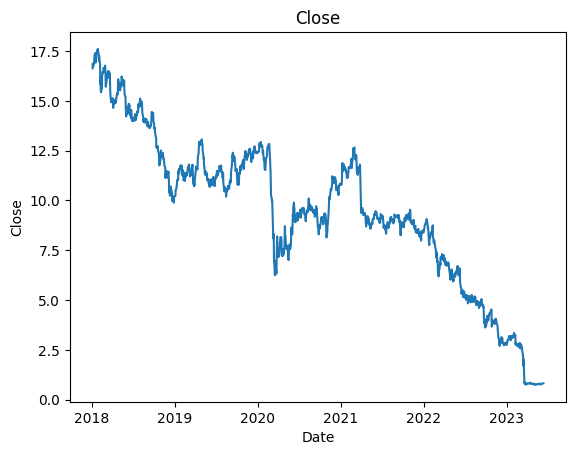

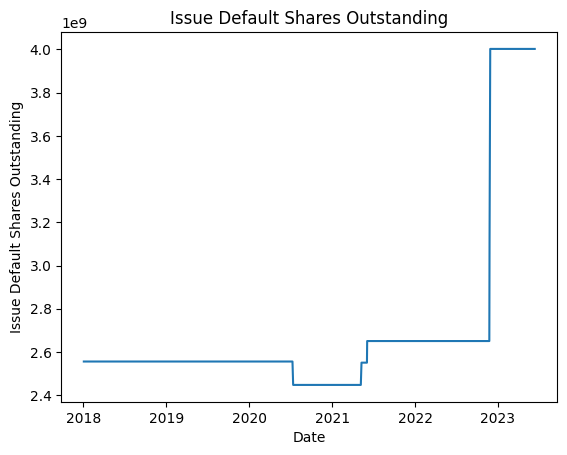

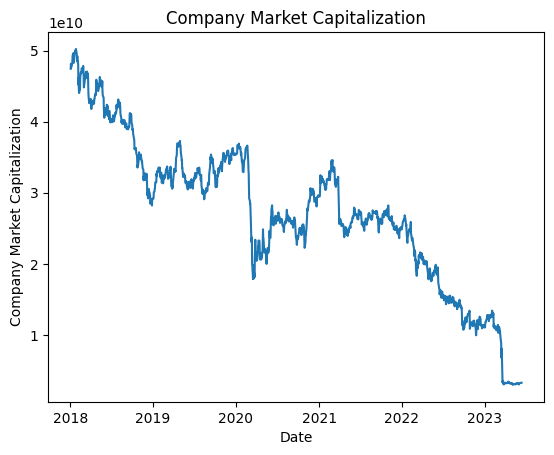

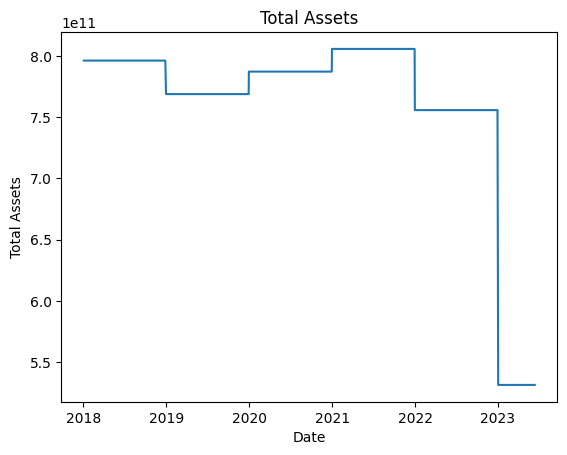

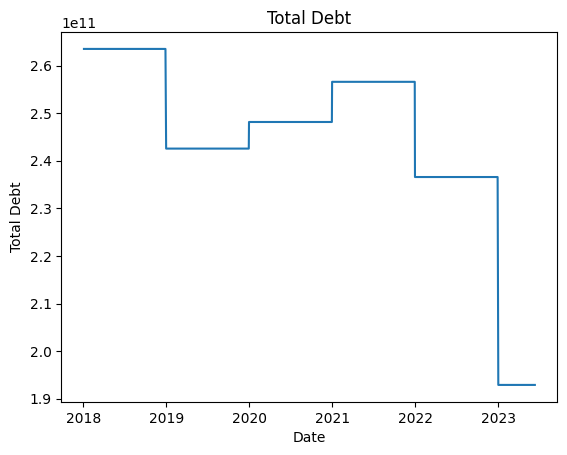

In [210]:
# ================================================================
#                        Plot the data
# ================================================================

def plot_input_data(stock_data: pd.DataFrame) -> None:
    """
    Plot the stock data. 
    """

    for col in input_data.columns:
        plt.figure()
        plt.plot(input_data.index, input_data[col])
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.savefig(f"images/{col}.png")

    plt.show()

plot_input_data(input_data)


$RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m}))$ (only applies if the triggers are not breached)

$L_k = \text{Total debt} / (\text{Total equity} + \text{Total debt}) = RQ_k / (RQ_k + NS_{k-1} * S_k)$

$\alpha = RQ_k / (RQ_k + \text{Book value of non CoCo debt})$

In [211]:
# ================================================================
#                    Calculate dependent variables
# ================================================================

def calculate_residual_value_of_dcl(Q, r, N_m, k):
    """
    Calculate the residual value of DCL bond at time k. 
    """

    return Q * ((1 + r)**k + (1 - (1 + r)**k)/(1 - (1 + r)**(-N_m)))

def calculate_alpha(RQ_k, book_value_of_non_coco_debt):
    """
    Calculate the ratio of CoCos to total debt. 
    """
    
    return RQ_k / (RQ_k + book_value_of_non_coco_debt)

def calculate_leverage_ratio(RQ_k, NS_k_1, S_k):
    """
    Calculate the leverage ratio. 
    """

    return RQ_k / (RQ_k + NS_k_1 * S_k)

def simulate_DCL(stock_data, Q_init, r, T, L_min, L_c):
    """
    Simulate the DCL model. 
    """

    stock_data['k'] = stock_data.index.year - stock_data.index.year[0]
    stock_data['Book value of debt'] = stock_data['Total Debt']
    # stock_data['Shares outstanding'] = stock_data['Common Shares - Outstanding - Total']
    stock_data['Shares outstanding'] = stock_data['Issue Default Shares Outstanding']
    stock_data['Q'] = Q_init
    stock_data['New debt issued'] = 0
    stock_data['New shares issued'] = 0

    for day in stock_data.index[0:]:

        previous_day = stock_data.index[stock_data.index.get_loc(day) - 1]
        stock_data.loc[day, 'Q'] = stock_data.loc[previous_day, 'Q']
        stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(stock_data.loc[day, 'Q'], r, T, stock_data.loc[day, 'k'])
        stock_data.loc[day, 'Alpha'] = calculate_alpha(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Book value of debt'])
        stock_data.loc[day, 'Leverage ratio'] = calculate_leverage_ratio(stock_data.loc[day, 'RQ_k'], stock_data.loc[day, 'Shares outstanding'], stock_data.loc[day, 'Close'])

        # Check if k changed
        if stock_data.loc[day, 'k'] != stock_data.loc[previous_day, 'k']:
            if stock_data.loc[day, 'Leverage ratio'] < L_min:
                print(f"{day} - Leverage ratio is below minimum: L_k = {stock_data.loc[day, 'Leverage ratio']}")
                stock_data.loc[day, 'New debt issued'] = -stock_data.loc[day, 'RQ_k'] + L_min * stock_data.loc[day, 'Shares outstanding'] * stock_data.loc[day, 'Close'] / (1 - L_min)
                print(f"{day} - New debt issued: {stock_data.loc[day, 'New debt issued']:,.2f}")
                stock_data.loc[day, 'Q'] = stock_data.loc[day, 'Q'] + stock_data.loc[day, 'New debt issued']

            elif stock_data.loc[day, 'Leverage ratio'] > L_c:
                print(f"{day} - Leverage ratio is above critical: L_k = {stock_data.loc[day, 'Leverage ratio']}")
                stock_data.loc[day, 'New shares issued'] = 1000000
                stock_data.loc[day, 'New shares issued'] = 0
                print(f"{day} - New shares issued: {stock_data.loc[day, 'New shares issued']}")
                # stock_data.loc[day, 'Shares outstanding'] = stock_data.loc[day, 'Shares outstanding'] + stock_data.loc[day, 'New shares issued']

    return stock_data

frequency = 1    # Frequency of interest payments
L_min = 0.40     # Minimum leverage ratio
L_c = 0.5        # Critical leverage ratio

cs_dcl_1 = simulate_DCL(
    stock_data = input_data,
    Q_init     = 10_216_000_000, # Initial value of DCL bonds
    r          = 0.05,           # Risk free rate TODO: change to 
    T          = 10,             # Number of years to maturity for DCL bonds
    L_min      = L_min,          # Minimum leverage ratio
    L_c        = L_c             # Critical leverage ratio
)
cs_dcl_1


2018-01-03 00:00:00 - Leverage ratio is below minimum: L_k = 0.1937603943387765
2018-01-03 00:00:00 - New debt issued: 18,123,275,559.19
2023-01-02 00:00:00 - Leverage ratio is above critical: L_k = 0.5895592489728061
2023-01-02 00:00:00 - New shares issued: 0


,Close,Issue Default Shares Outstanding,Company Market Capitalization,Total Assets,Total Debt,k,Book value of debt,Shares outstanding,Q,New debt issued,New shares issued,RQ_k,Alpha,Leverage ratio
2018-01-03,16.630954,2.556012e+09,4.744485e+10,7.962890e+11,2.634910e+11,0,2.634910e+11,2.556012e+09,2.833928e+10,1.812328e+10,0,1.021600e+10,0.037325,0.193760
2018-01-04,16.877058,2.556012e+09,4.814694e+10,7.962890e+11,2.634910e+11,0,2.634910e+11,2.556012e+09,2.833928e+10,0.000000e+00,0,2.833928e+10,0.097109,0.396480
2018-01-05,16.697213,2.556012e+09,4.763387e+10,7.962890e+11,2.634910e+11,0,2.634910e+11,2.556012e+09,2.833928e+10,0.000000e+00,0,2.833928e+10,0.097109,0.399046
2018-01-08,16.824997,2.556012e+09,4.799842e+10,7.962890e+11,2.634910e+11,0,2.634910e+11,2.556012e+09,2.833928e+10,0.000000e+00,0,2.833928e+10,0.097109,0.397219
2018-01-09,16.867592,2.556012e+09,4.811993e+10,7.962890e+11,2.634910e+11,0,2.634910e+11,2.556012e+09,2.833928e+10,0.000000e+00,0,2.833928e+10,0.097109,0.396614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,4.002158e+09,3.240147e+09,5.313580e+11,1.929070e+11,5,1.929070e+11,4.002158e+09,2.833928e+10,0.000000e+00,0,1.588946e+10,0.076100,0.830621
2023-06-07,0.810200,4.002158e+09,3.242548e+09,5.313580e+11,1.929070e+11,5,1.929070e+11,4.002158e+09,2.833928e+10,0.000000e+00,0,1.588946e+10,0.076100,0.830517
2023-06-08,0.811000,4.002158e+09,3.245750e+09,5.313580e+11,1.929070e+11,5,1.929070e+11,4.002158e+09,2.833928e+10,0.000000e+00,0,1.588946e+10,0.076100,0.830378
2023-06-09,0.808000,4.002158e+09,3.233744e+09,5.313580e+11,1.929070e+11,5,1.929070e+11,4.002158e+09,2.833928e+10,0.000000e+00,0,1.588946e+10,0.076100,0.830900


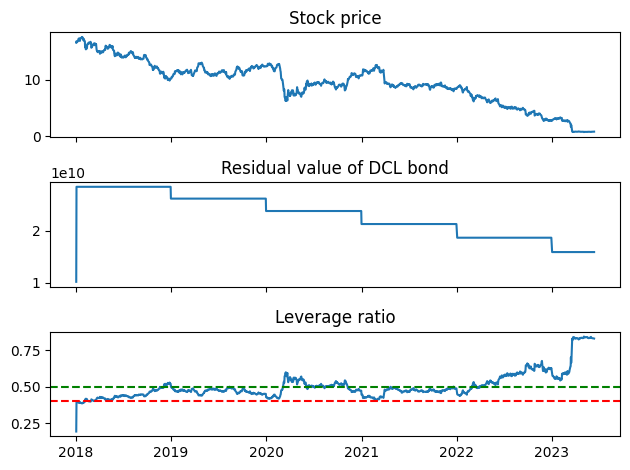

In [212]:
# ================================================================
#                        Plot the results
# ================================================================

def plot_results(df: pd.DataFrame) -> None:
    """
    Plot the results. 
    """

    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].plot(df.index, df['Close'], label='Close')
    ax[0].set_title('Stock price')
    # TODO: Add shares outstanding plot
    ax[1].plot(df.index, df['RQ_k'], label='RQ_k')
    ax[1].set_title('Residual value of DCL bond')
    # TODO: Add alpha plot
    # TODO: Add new debt issued plot
    ax[2].plot(df.index, df['Leverage ratio'], label='Leverage ratio')
    ax[2].set_title('Leverage ratio')
    ax[2].axhline(y=L_min, color='r', linestyle='--', label='L_min')
    ax[2].axhline(y=L_c, color='g', linestyle='--', label='L_c')
    plt.tight_layout()
    plt.savefig("images/results.png")
    plt.show()

plot_results(cs_dcl_1)
